### Info about project

The aim of this project was to prepare a CNN model, train it, analyze and discuss the results and test it to see how the prediction works. A dataset on tomato leaf diseases was used for the project.

This dataset contains two directories:

*   train - where one can find 9 catalogues with leaf diseases pictures and one with healthy leaves (each catalogue has 1000 pictures inside)
*   val - where one can find 9 catalogues with leaf diseases pictures and one with healthy leaves (each catalogue has 100 pictures inside)

The list of cathegories:
* Tomato_mosaic_virus
* Target_Spot
* Bacterial_spot
* Tomato_Yellow_Leaf_Curl_Virus
* Late_blight
* Leaf_Mold
* Early_blight
* Spider_mites Two-spotted_spider_mite
* Tomato___healthy
* Septoria_leaf_spot

In [ ]:
#@title Importing the necessary libraries

import os
import pandas as pd
import numpy as np
import tensorflow as tf


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, InputLayer, Dropout, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping as ES
from IPython.display import clear_output as cls


import plotly.express as px
import matplotlib.pyplot as plt

In [ ]:
#@title Downloading and unpacking dataset

!pip install unrar
!pip install gdown
import gdown

!mkdir my_data

url = 'https://drive.google.com/uc?id=1iQMsol_CeSE9Di-p-VqIOKK-z78vbaTV'
output = 'tomato.rar'
gdown.download(url, output, quiet=False)

!unrar x /content/tomato.rar /content/my_data

Downloading...
From: https://drive.google.com/uc?id=1iQMsol_CeSE9Di-p-VqIOKK-z78vbaTV
To: /content/tomato.rar
100%|██████████| 188M/188M [00:00<00:00, 285MB/s]


Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
Extracting  /content/my_data/train/Tomato___Septoria_leaf_spot/057115de-0a9b-4e3a-b98f-7ba3ce174b8f___Keller.St_CG 1800.JPG      51%  OK 
Extracting  /content/my_data/train/Tomato___Septoria_leaf_spot/06225525-413e-411b-a503-85e8dc6050a8___JR_Sept.L.S 8351.JPG      51%  OK 
Extracting  /content/my_data/train/Tomato___Septoria_leaf_spot/0648ab1f-53de-4c70-9854-10f0794cb30c___Matt.S_CG 7480.JPG      51%  OK 
Extracting  /content/my_data/train/Tomato___Septoria_leaf_spot/0650f176-add9-444e-893e-707969054a43___JR_Sept.L.S 2722.JPG      51%  OK 
Extracting  /content/my_data/train/Tomato___Septoria_leaf_spot/0663ec0d-8837-4ba8-82a4-89d8a07ca206___Matt.S_CG 0714.JPG      51%  OK 
Extracting  /content/my_data/train/Tomato___Septoria_leaf_spot/06778fed-2b98-49b1-a9d3-d57765586a3f___Matt.S_CG 2795.JPG      51%  OK 
Extracting  /content/my_data/train/Tomato___Septoria_leaf_spot/0

In [ ]:
# Creating variables with directories

#Pictures from this directory will be divided into training and validation sets
train_dir = 'my_data/train/'

#Pictures from this directory will be used for testing
val_dir =  'my_data/val/'

In [ ]:
imageShape = (224, 224)
batchSize = 32
input_shape=(224, 224, 3)

In [ ]:
#@title Initial data handling and assignment to training, validation and testing sets

# Preparation for normalisation and data splitting
train_gen = ImageDataGenerator(rescale=(1./255.), validation_split=0.2)
val_gen = ImageDataGenerator(rescale=(1./255.))

# Dividing data into 3 subsets
train_data = train_gen.flow_from_directory(train_dir,target_size=imageShape,batch_size=batchSize, subset='training', class_mode='categorical')
val_data = train_gen.flow_from_directory(train_dir,target_size=imageShape,batch_size=batchSize, subset='validation', class_mode='categorical')
test_data = val_gen.flow_from_directory(val_dir,target_size=imageShape,batch_size=batchSize, class_mode='categorical')

# Sorting class names
class_names = sorted(os.listdir(train_dir))

Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [ ]:
#@title Displaying random images from random cathegories
def plot_images(data, class_names):

    # Define number of rows
    rows = 3
    # Define number of columns
    columns = 5
    # Define exit flag after reaching limit
    imgLen = rows*columns

    plt.figure(figsize=(20, 10))
    i = 1

    # Loop through the pictures and labels
    for images, labels in iter(data):

        id = np.random.randint(len(images))
        img = tf.expand_dims(images[id], axis=0)
        lab = class_names[np.argmax(labels[id])]

        # Display the picture and label in the current subplot
        plt.subplot(rows, columns, i)
        plt.imshow(img[0])
        plt.title(lab)
        plt.axis('off')
        cls()

        i+=1
        if i > imgLen:
            break

    # Adjust the spacing between subplots
    plt.tight_layout()
    # Display the grid of pictures and labels
    plt.show()

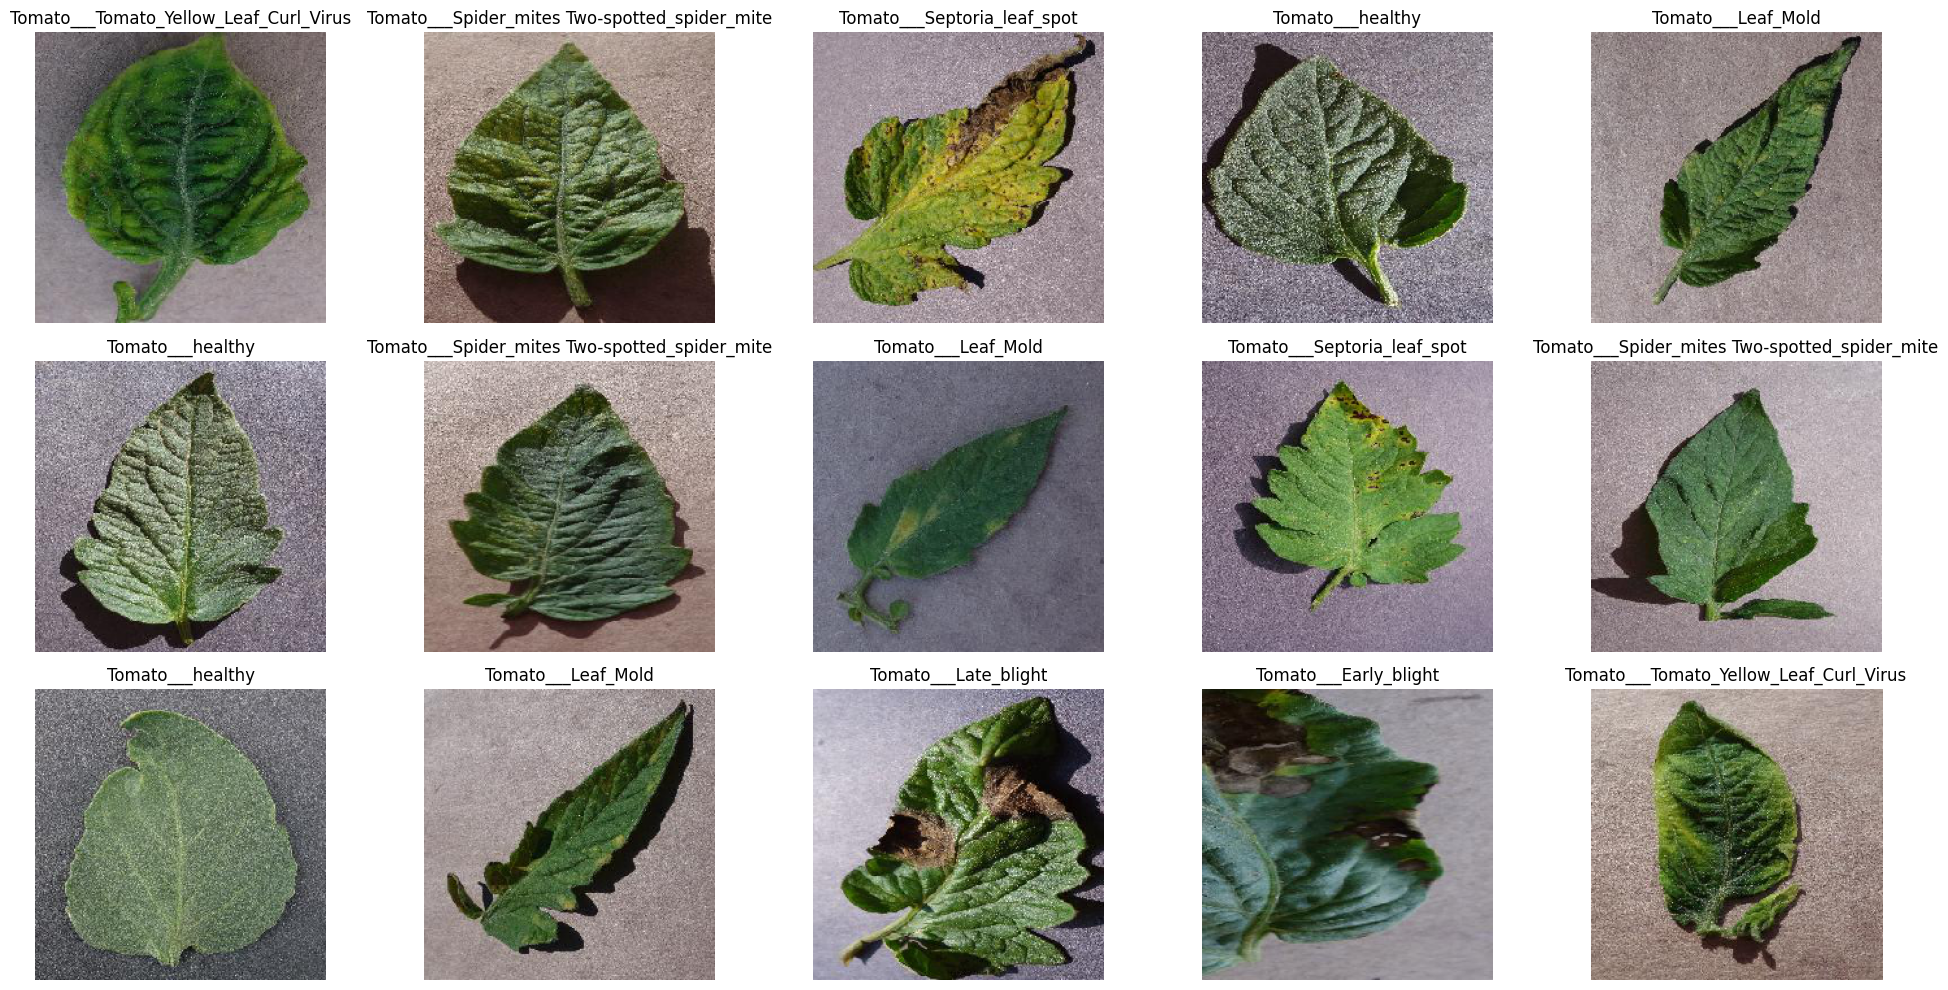

In [ ]:
plot_images(train_data, class_names)

In [ ]:
#@title Building the CNN model

model = Sequential()

model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(256,(3,3),activation='relu'))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(10,'sigmoid'))

model.compile('Adam','binary_crossentropy',['accuracy'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 conv2d_13 (Conv2D)          (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 110, 110, 64)     0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 108, 108, 64)      36928     
                                                                 
 conv2d_15 (Conv2D)          (None, 106, 106, 128)     73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 53, 53, 128)      0         
 2D)                                                  

In [ ]:
#@title Training the model
history = model.fit(train_data,
                   validation_data=val_data,
                   epochs=15,
                   steps_per_epoch=len(train_data),
                   validation_steps=len(val_data),
                   callbacks=[ES(monitor="val_loss", patience=5)])

Epoch 1/15
250/250 [==============================] - 81s 299ms/step - loss: 0.2683 - accuracy: 0.3569 - val_loss: 0.1832 - val_accuracy: 0.6035
Epoch 2/15
250/250 [==============================] - 71s 285ms/step - loss: 0.1611 - accuracy: 0.6666 - val_loss: 0.1342 - val_accuracy: 0.7340
Epoch 3/15
250/250 [==============================] - 76s 303ms/step - loss: 0.1147 - accuracy: 0.7789 - val_loss: 0.0915 - val_accuracy: 0.8275
Epoch 4/15
250/250 [==============================] - 76s 302ms/step - loss: 0.0857 - accuracy: 0.8426 - val_loss: 0.0963 - val_accuracy: 0.8125
Epoch 5/15
250/250 [==============================] - 71s 284ms/step - loss: 0.0757 - accuracy: 0.8602 - val_loss: 0.0731 - val_accuracy: 0.8730
Epoch 6/15
250/250 [==============================] - 72s 287ms/step - loss: 0.0521 - accuracy: 0.9124 - val_loss: 0.0780 - val_accuracy: 0.8500
Epoch 7/15
250/250 [==============================] - 72s 286ms/step - loss: 0.0454 - accuracy: 0.9205 - val_loss: 0.0593 - val_ac

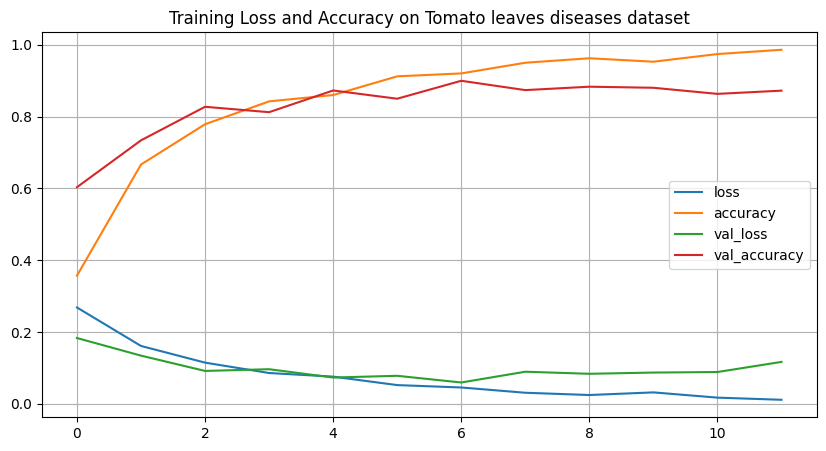

In [ ]:
#@title Plotting Accuracy and Loses
learningcurve = pd.DataFrame(history.history)
learningcurve.plot(figsize=(10, 5))
plt.title("Training Loss and Accuracy on Tomato leaves diseases dataset")
plt.grid()

In [ ]:
#@title Displaying random images from testing dataset and predicting their class
def predict_images(data, class_names, model):

    # Define number of rows
    rows = 3
    # Define number of columns
    columns = 5
    # Define exit flag after reaching limit
    imgLen = rows*columns

    plt.figure(figsize=(20, 10))
    i = 1

    # Loop through the pictures and labels
    for images, labels in iter(data):

        id = np.random.randint(len(images))
        img = tf.expand_dims(images[id], axis=0)

        # Display the picture and label in the current subplot
        plt.subplot(rows, columns, i)
        plt.imshow(img[0])

        # Prediction
        predicted = model.predict(img)
        predicted = class_names[np.argmax(predicted)]
        actual = class_names[np.argmax(labels[id])]

        plt.title(f"Actual: {actual}\nPredicted: {predicted}")
        plt.axis('off')
        cls()

        i+=1
        if i > imgLen:
            break

    # Adjust the spacing between subplots
    plt.tight_layout()
    # Display the grid of pictures and labels
    plt.show()

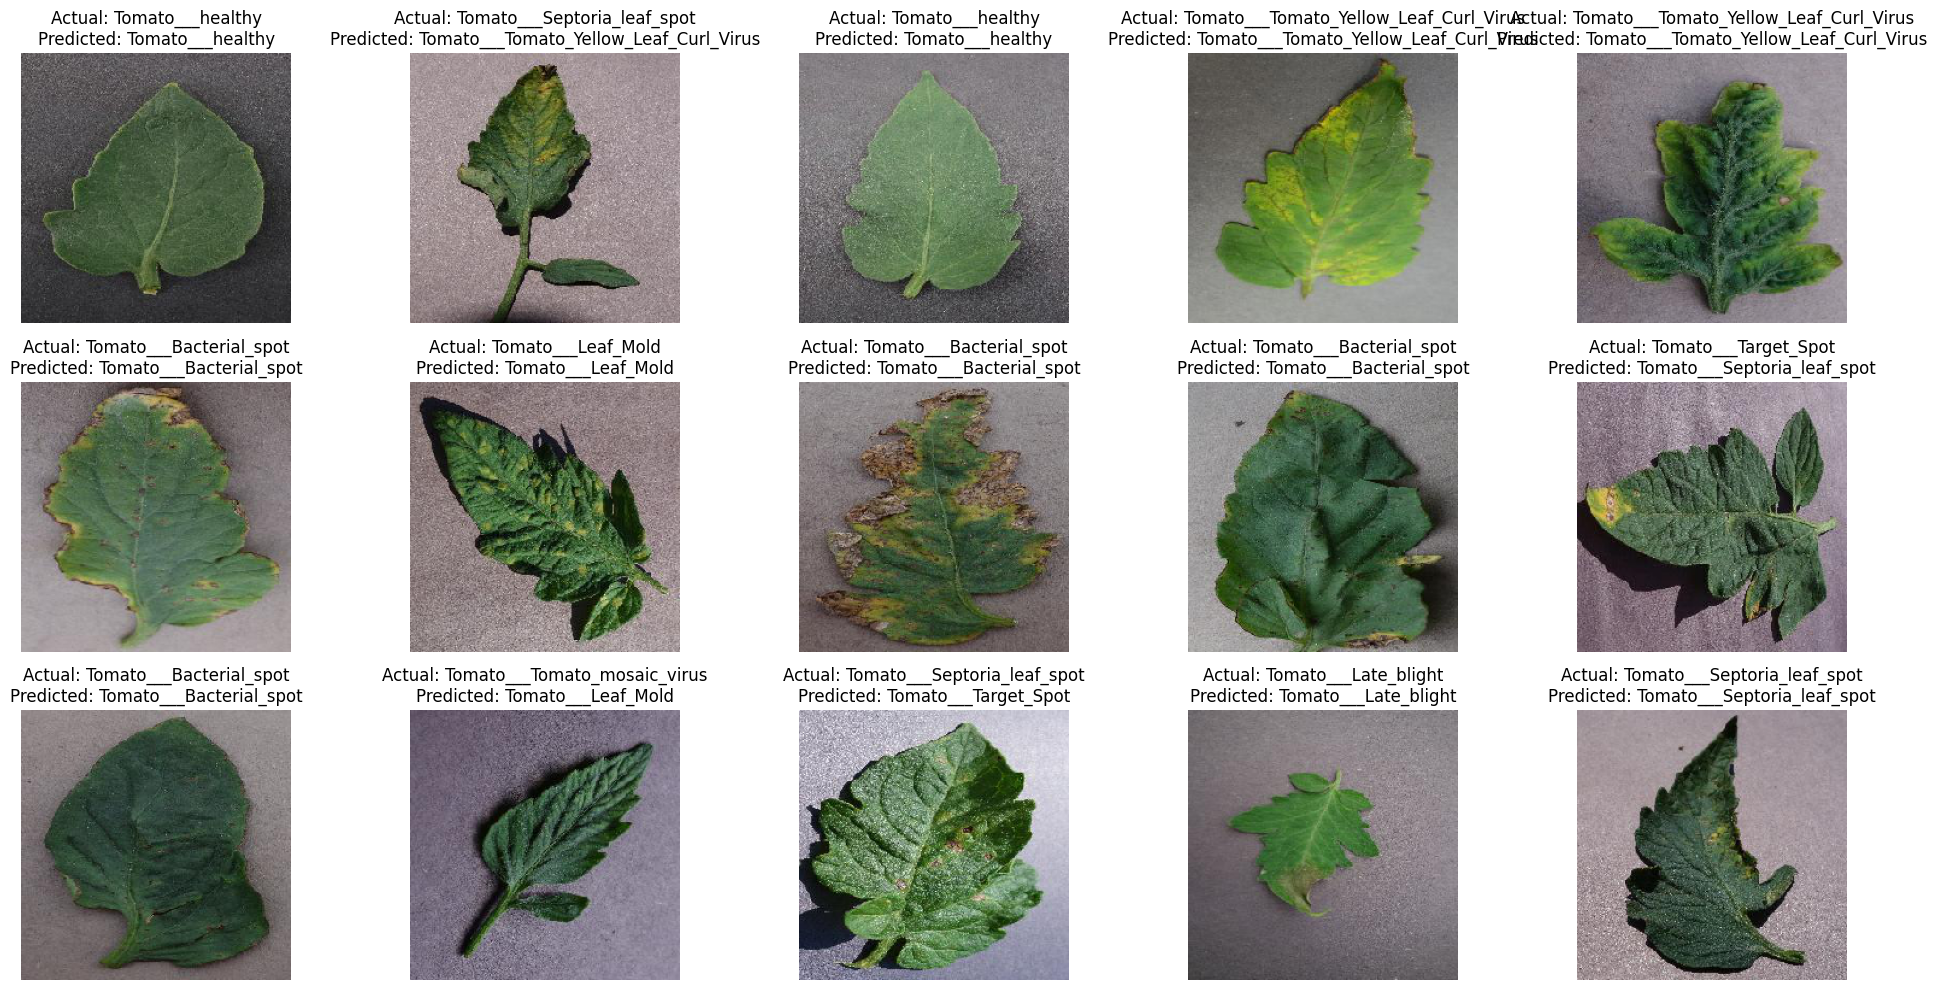

In [ ]:
predict_images(test_data, class_names, model)

# Summary
After training the model and making predictions on the test set, it can be seen
that the model, despite the fact that it is not very complicated, is doing quite well considering that the data in the data set at first glance seem to be complicated.

* At the beginning of training my model, we can see that the accuracy on the training set is about 0.30 and the accuracy on the validation set is about 0.60, while the loss is equal to ~0.26 and ~0.18 respectively. At this point, it is safe to say that the loss we received at the very beginning is not high. When training in successive epochs, you can see a significant decrease in loss both on training set and validation set, while the accuracy on both sets increases moderately, not sharply. This proves that the model training process is proceeding correctly. From epoch 8, you can see that the model's training results begin to stabilize. Accuracy on the training set up to the 12th epoch slightly increases (training from 0.95 to 0.98), while on the validation set the accuracy value remains at the same level. The loss value in both crops since epoch 8 also remains at a similar level or slightly decreases. Due to the strongly stabilizing results, the training, thanks to the callback function (it is called when the training results have not improved significantly since the specified time), ends at epoch 12.

* If we did not use the callback, we would get very similar results for the next few epochs, which would only confirm that the training entered the phase of stabilization and stagnation, and then it could end with overfitting.

* Looking at the current results, the training could have ended at epoch 8. It was set to 15 epochs to observe its further behavior, which was needed to draw conclusions.

* In the end, it can be said that the training went quite well, and its results are possible and satisfactory. Both loss values decreased and accuracy increased. The validation accuracy is slightly lower than the accuracy on the training set, and the validation loss is slightly higher than the loss on the training set, which is a good result.

* When checking the prediction on the test set, you can see that the model performs quite well. He is able to predict the vast majority of classes, but he can also be wrong at times. Also thanks to this we know that the model is not overfitted.

* Due to the fact that the process of training the model went well and had no problems with learning (achieved good results), I decided not to use data augmentation methods.

* Using the sigmoid function (it was used because there are photos where two separate leaf blades grow from one petiole) instead of softmax at the end of my model's structure brought good results.